In [58]:
import pickle
from os.path import join
import matplotlib.pyplot as plt

from correlate import zero_lag_correlate

In [66]:
import numpy as np
a = np.random.randn(1000)
b = np.random.randn(1000)
np.nanmean(zero_lag_correlate(a,b, wind_s = 1))

0.009700837140074163

In [4]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
with open(join(result_dir, 'windv1.pkl'), 'rb') as f:
    wind = pickle.load(f)

In [52]:
wind_copy = wind.copy()

In [46]:
wind_copy.loc[wind_copy.sd_delta<0, 'sd_delta'] = 0
# wind_copy.sd_delta = wind_copy.sd_delta.round(1)

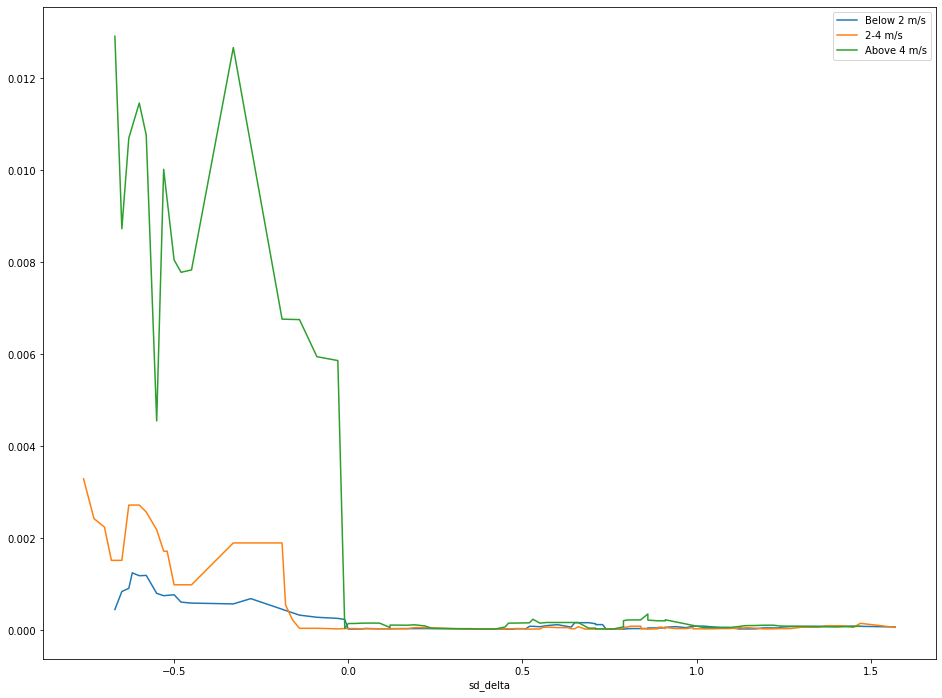

In [57]:
f, ax = plt.subplots(figsize = (16,12))
wind_copy[wind_copy.wind < 1].groupby(by = 'sd_delta').mean().power.rolling(window = 5).mean().plot(label = 'Below 2 m/s', ax = ax )
wind_copy[(wind_copy.wind > 1) & (wind_copy.wind < 6)].groupby(by = 'sd_delta').mean().power.rolling(window = 5).median().plot(label = '2-4 m/s', ax = ax )
wind_copy[wind_copy.wind > 6].groupby(by = 'sd_delta').mean().power.rolling(window = 5).mean().plot(label = 'Above 4 m/s', ax = ax )
plt.legend()
# plt.xlim(0, 1.5)
# plt.ylim(0, 0.001)